#**Applying Unsupervised Learning to FDA Inspections and Citations**

#####FDA is a US agency responsible for assuring the safety and quality of foods, medicines, and cosmetics entering the US. One of its robust set of tools is inspection of domestic and foreign manufacturers and market authority holders. This analysis focused on biologics, devices, and drugs. 

Excluding few cases, FDA classifies inspections into one of the following:

*   No Action Indicated (NAI)
*   Voluntary Action Indicated (VAI)
*   Official Action Indicated (OAI)

Inspections are classified NAI if no objectionable conditions (i.e. observations) are found. Inspections are classified OAI if serious violations to rules and regulations are found. OAI inspections often result in enforcement actions such as warning letters, consent decrees and import alerts to stop manufacturing within US or prevent shipment of products into US. All other inspections are classified VAI.

In this project, the goal is to characterize inspections classified OAI or NAI in Human Drugs, Biologics, and Medical Devices.



# **1. Import Libraries**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler, PowerTransformer
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, log_loss

!pip install umap-learn
import umap
from umap import umap_
!pip install kmodes
from kmodes.kprototypes import KPrototypes
import xgboost
from xgboost import XGBClassifier

import warnings

#**2. Load & Merge Data Sources**

#####FDA publishes inspectional data from 2008 to present. Published data sets do not represent all inspections as the FDA neither publishes Pre-Approval Inspections (PAI) nor includes inspection reports submitted in paper.

In [2]:
# Load data sources

url1 = 'https://www.fda.gov/media/79333/download' # FDA inspectional classification
df1 = pd.read_excel(url1)
url2 = 'https://www.fda.gov/media/107480/download' # FDA inspectional observations
df2 = pd.read_excel(url2)

In [3]:
# Merge inspectional classification and inspectional citations data sources

# Outer join to include inspections classified NAI as inspections in right dataframe are never classified NAI
df = pd.merge(df1, df2, how='outer', 
              left_on=['Legal Name', 'Inspection End Date'], 
              right_on=['Firm Name', 'Inspection End Date']
              )

df = df[['Firm Name', 'Country/Area_y', 'Program Area', 'Inspection End Date', 
         'Classification', 'CFR/Act Number', 'Short Description', 
         'Long Description']]

df = df.rename(columns={'Country/Area_y':'Country'})

df.drop_duplicates(inplace=True)

In [4]:
# Dataframe lists citations 

df.tail(3)

,Firm Name,Country,Program Area,Inspection End Date,Classification,CFR/Act Number,Short Description,Long Description
480841,UCC UESHIMA COFFEE CO.(AMERICA) Inc.,United States,Foods,2020-09-11,NaN,21 CFR 1.506(a)(1),Approved supplier procedures - importer establ...,You did not establish written procedures to en...
480842,UCC UESHIMA COFFEE CO.(AMERICA) Inc.,United States,Foods,2020-09-11,NaN,21 CFR 1.506(e)(1),"Verification activity before import, periodically",You did not conduct and document or obtain doc...
480843,UCC UESHIMA COFFEE CO.(AMERICA) Inc.,United States,Foods,2020-09-11,NaN,21 CFR 1.506(b),Supplier verification - establish written proc...,You did not establish written procedures for e...


#**3. Data Processing**

###**3.1. Data Cleaning**

In [5]:
# Check for missing values

((df
  .isna()
  .mean()
  *100)
  .pipe(lambda ser : ser[ser > 0])
)

# Only Inspection End Date column has no missing values

Firm Name            3.062023
Country              3.062023
Program Area         3.062023
Classification       0.876507
CFR/Act Number       3.129505
Short Description    3.062023
Long Description     3.063173
dtype: float64

In [6]:
df['Classification'].value_counts(dropna=False)

VAI    177581
OAI     42846
NAI     38095
NaN      2286
Name: Classification, dtype: int64

In [7]:
df[df['Classification'].isna()]['Program Area'].value_counts(dropna=False)

Foods                               1246
Devices                              385
Drugs                                378
Veterinary Medicine                   98
Human Tissue for Transplantation      58
Parts 1240 and 1250                   45
Biologics                             41
Bioresearch Monitoring                31
Part 11 Compliance                     4
Name: Program Area, dtype: int64

In [8]:
# Countries ranked by citation count in descending order

(df['Country'].value_counts().to_frame().reset_index()
).rename(columns={'Country':'Count','index':'Country'})['Country'].head(10)

0              United States
1                      India
2                     Canada
3                    Germany
4                      Italy
5    Korea (the Republic of)
6                      China
7                      Japan
8             United Kingdom
9                      Spain
Name: Country, dtype: object

###**3.2. Feature Engineering**

Since the merged dataframe is indexed by observations and this project aims to characterize inspection classification, I am grouping all the observations by inspection and counting the number of citations. I am also imputing the data, creating a regional feature, and filtering the inspections to those of my interest:


*   Human Drugs
*   Biologics
*   Devices



In [9]:
# Dictionary to group countries into regions

dict_region = {'NA':['United States','Canada'],
              'APAC':['Thailand','Taiwan','Japan','China','India','Fiji','Philippines',
                      'Korea (the Republic of)','Singapore','Malaysia','Vietnam',
                      'Indonesia','Australia','Hong Kong SAR','Bangladesh','Macao',
                      'Maldives','French Polynesia','New Zealand','Sri Lanka',
                      'Western Samoa'],
              'EMEA':['Germany','Sweden','United Kingdom','Netherlands','Hungary',
                      'Russia','Czech Republic','Ireland','France','Spain','Switzerland',
                      'Italy', 'Portugal','Belgium','Denmark','South Africa','Slovakia',
                      'Israel','Austria','Greece','Norway','Poland','Romania','Croatia',
                      'Saudi Arabia','Egypt','Jordan','Ghana','Oman','Finland','Bulgaria',
                      'Serbia','Turkey','Slovenia','Tunisia','Morocco','Tonga','Belarus',
                      'Estonia','Madagascar','Macedonia','Malawi','Ukraine','Malta',
                      'Lithuania','Monaco','Iceland','Senegal','Latvia','Cyprus',
                      'Liechtenstein','Bosnia-Hercegovina','Armenia',
                      'United Arab Emirates','Georgia','Cape Verde','Faroe Islands',
                      'Ivory Coast','Mauritius'],
              'LATAM':['Ecuador','Peru','Mexico','Dominican Republic (the)',
                      'Guatemala','Columbia','Brazil','Chile','Costa Rica',
                      'Nicaragua','Panama','Venezuela','Barbados','Argentina',
                      'Paraguay','Surinam','El Salvador','Trinidad & Tobago',
                      'St. Vincent & The Grenadines','Bolivia','Bahamas','Jamaica',
                      'Uruguay','Belize','Grenada','Guyana','Colombia']
              }

In [10]:
def count_citation(df):
  
  """Function counts citations per inspections and imputes data"""

  df.loc[(df['Classification'] == 'OAI') | (df['Classification'] == 'VAI'),'Citations'] = 1
  df.loc[df['Classification'] == 'NAI','Citations'] = 0
  df['Program Area'].replace({'Foods':'Other',
                       'Veterinary Medicine':'Other',
                       'Bioresearch Monitoring':'Other',
                       'Human Tissue for Transplantation': 'Other',
                       'Parts 1240 and 1250': 'Other',
                       'Radiologic Health': 'Other',
                       'Part 11 Compliance': 'Other'},
                       inplace=True
                       )
  def limit_domestic(val):
    if val in {'United States'}:
      return 'Domestic'
    return 'Foreign'
  df['Domestic'] = df['Country'].apply(limit_domestic)
  df['Region'] = df['Country']
  for k in dict_region.keys():
    df.loc[df['Country'].isin(dict_region[k]), 'Region'] = k
  df = df.groupby(['Firm Name', 
                    'Country',
                    'Region', 
                    'Domestic',
                    'Inspection End Date', 
                    'Program Area',
                    'Classification'])['Citations'].sum().reset_index()
  df = df[df['Program Area'] != 'Other']
  df.sort_values(by=['Inspection End Date'], inplace=True, ascending=True)
  df = df.reset_index().drop('index', axis=1)
  df = df.astype({'Citations':int})
  return df

In [11]:
count_citation(df)

,Firm Name,Country,Region,Domestic,Inspection End Date,Program Area,Classification,Citations
0,Pekana Naturheilmittel GmbH,Germany,EMEA,Foreign,2008-10-02,Drugs,VAI,3
1,"EyeKon Medical, Inc.",United States,NA,Domestic,2008-10-03,Devices,NAI,0
2,"EyeKon Medical, Inc.",United States,NA,Domestic,2008-10-03,Devices,OAI,13
3,"Translite, LLC",United States,NA,Domestic,2008-10-03,Devices,VAI,3
4,"Translite, LLC",United States,NA,Domestic,2008-10-03,Devices,NAI,0
...,...,...,...,...,...,...,...,...
22905,National Advanced Endoscopy Devices Inc,United States,NA,Domestic,2020-09-03,Devices,VAI,1
22906,"J & J Instruments, LLC",United States,NA,Domestic,2020-09-16,Devices,VAI,1
22907,"J & J Instruments, LLC",United States,NA,Domestic,2020-09-16,Devices,NAI,0
22908,Wayne County Chapter of NYARC,United States,NA,Domestic,2020-09-16,Drugs,VAI,6


In [12]:
# Update dict if there are regions other than NA, EMEA, APAC, and LATAM

count_citation(df)['Region'].value_counts(dropna=False)

NA       19643
EMEA      1823
APAC      1336
LATAM      108
Name: Region, dtype: int64

#**4. Exploratory Data Analysis**

In [13]:
def prep_viz(df, start_date=False, encode_class=False):

  """Function prepares dataframe for data visualizations by filtering 
  date and encoding observation classification as needed"""

  if start_date:
    df = df[df['Inspection End Date'] >= start_date]
  if encode_class:
    df['Classification'] = df['Classification'].replace({'NAI':0,'VAI':1,'OAI':2})
    df = df.astype({'Classification':int})
  df.sort_values(by=['Inspection End Date'], inplace=True, ascending=True)
  df = df.reset_index().drop('index', axis=1)
  df['Year'] = df['Inspection End Date'].dt.year
  return df

prep_viz(count_citation(df), start_date='2015-01-01', encode_class=True).head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Firm Name,Country,Region,Domestic,Inspection End Date,Program Area,Classification,Citations,Year
0,ITxM Clinical Services,United States,NA,Domestic,2015-01-02,Biologics,1,3,2015
1,"Brewer Company, LLC",United States,NA,Domestic,2015-01-05,Devices,1,6,2015
2,Arcet Equipment Company dba Arc3 Gases North,United States,NA,Domestic,2015-01-05,Drugs,1,1,2015
3,Bard Peripheral Vascular Inc,United States,NA,Domestic,2015-01-05,Devices,2,3,2015
4,Fisher Wallace Laboratories Inc.,United States,NA,Domestic,2015-01-06,Devices,0,0,2015


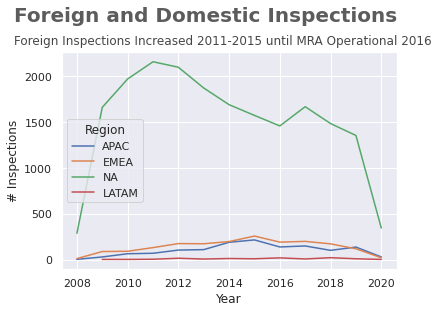

In [14]:
# Foreign and Domestic Inspections

data = prep_viz(count_citation(df), start_date='2008-01-01')
data = data.groupby(['Year', 'Region']).count().reset_index()

sns.set(style='darkgrid')
g = sns.lineplot(x='Year',
             y='Firm Name',
             hue='Region',
             data=data)
g.text(x=2005.5, 
       y=2600, 
       s='Foreign and Domestic Inspections',
       fontsize=20, 
       weight='bold', 
       alpha=.75)
g.text(x=2005.5, 
       y=2350,
       s='Foreign Inspections Increased 2011-2015 until MRA Operational 2016',
       fontsize=12, 
       alpha=.85)
plt.xlabel('Year')
plt.ylabel('# Inspections')
plt.show()

# Inspections remain high in NA, but there is decreasing trend as FDA focuses on foreign inspections

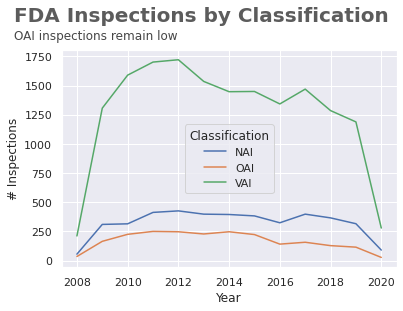

In [15]:
# FDA Inspections by Classification

data = prep_viz(count_citation(df))
data = data.groupby(['Year', 'Classification']).count().reset_index()

sns.set(style='darkgrid')
g = sns.lineplot(x='Year',
             y='Firm Name',
             hue='Classification',
             data=data)
g.text(x=2005.5, 
       y=2050, 
       s='FDA Inspections by Classification',
       fontsize=20, 
       weight='bold', 
       alpha=.75)
g.text(x=2005.5, 
       y=1900,
       s='OAI inspections remain low',
       fontsize=12, 
       alpha=.85)
plt.xlabel('Year')
plt.ylabel('# Inspections')
plt.show()

# FDA classifies inspections as VAI more often than NAI, and classifies inspections NAI more often than OAI

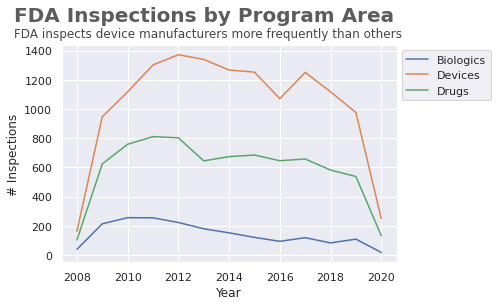

In [16]:
# FDA Inspections by Program Area

data = prep_viz(count_citation(df))
data = data.groupby(['Year', 'Program Area']).count().reset_index()

sns.set(style='darkgrid')
g = sns.lineplot(x='Year',
             y='Firm Name',
             hue='Program Area',
             data=data)
g.text(x=2005.5, 
       y=1600, 
       s='FDA Inspections by Program Area',
       fontsize=20, 
       weight='bold', 
       alpha=.75)
g.text(x=2005.5, 
       y=1490,
       s='FDA inspects device manufacturers more frequently than others',
       fontsize=12, 
       alpha=.85)
g.legend(bbox_to_anchor=(1,1))
plt.xlabel('Year')
plt.ylabel('# Inspections')
plt.show()

# FDA inspects device manufacturers more often than drug manufacturers

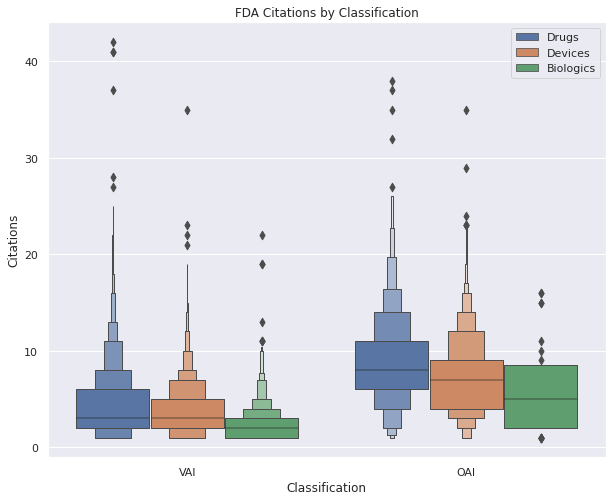

In [17]:
# Boxenplot of FDA Citations by Classification

data = prep_viz(count_citation(df))
data = data[~(data['Classification'] == 'NAI')] # NAI classification = 0 citations

f, ax = plt.subplots(figsize=(10,8))
g = sns.boxenplot(x='Classification', 
              y='Citations', 
              hue='Program Area', 
              data=data)
g.legend(bbox_to_anchor=(1,1))
plt.title('FDA Citations by Classification')
plt.show()

# Inspections classified OAI have higher median citation counts than inspections classified VAI
# However, there are notable outliers in VAI dataset where there are two inspections with more citations than any other inspection in the OAI dataset

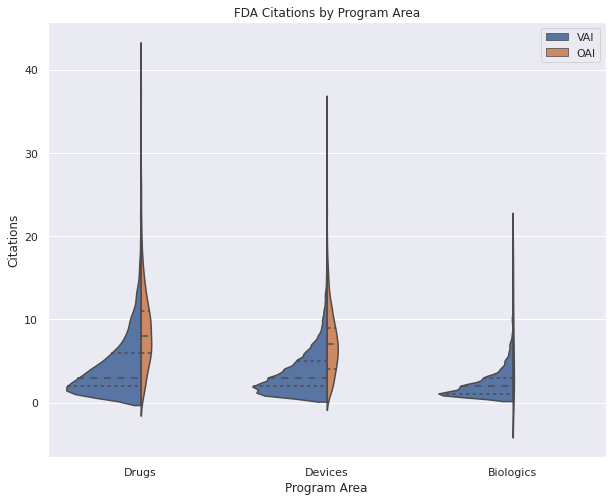

In [18]:
# Violinplot of FDA Citations by Program Area

data = prep_viz(count_citation(df))
data = data[~(data['Classification'] == 'NAI')] # NAI classification = 0 citations

f, ax = plt.subplots(figsize=(10,8))
g = sns.violinplot(x='Program Area', y='Citations', hue='Classification',
                    data=data, palette='deep', split=True,
                    scale='count', inner='quartile')
g.legend(bbox_to_anchor=(1,1))
plt.title('FDA Citations by Program Area')
plt.show()

# In all programs, citations in VAI dataset is skewed left (which consumers want) while citations in OAI are more normal but more variance

#**5. Cluster Analysis**

Uniform Manifold Approximation and Projection (UMAP) is used to qualitatively determine K, and KPrototypes to cluster the inspections data containing mixed type data.

###**5.1. UMAP**

We use UMAP to visualize and compare clusters by embedding high-dimensional data into two dimensions similar to PCA and t-SNE. Here is the procedure:

1.   Split features into numeric and categorical
2.   Apply PowerTransformer() to numeric features and one-hot encoding to categorical features
3.   Embed features separately using different metrics: 'l2' for numeric and 'dice' for categorical
4.   Combine embeddings as suggested [here](https://github.com/lmcinnes/umap/issues/58#issuecomment-419682509)

Inspiration comes from [Antons Ruberts](https://github.com/AntonsRuberts)

In [19]:
# Final feature selection
final_data = count_citation(df).drop(columns=['Inspection End Date','Domestic',
                                              'Firm Name','Country'])

In [20]:
# Preprocess numeric features
num_cols = final_data.select_dtypes(exclude='object')
for col in num_cols.columns:
  pt = PowerTransformer() # Transforms datapoints for Gaussian-like distribution
  num_cols.loc[:, col] = pt.fit_transform(np.array(num_cols[col]).reshape(-1, 1))
    
# Preprocess categorical features
cat_cols = final_data.select_dtypes(include='object')
cat_cols = pd.get_dummies(cat_cols)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [21]:
# Percentage of categorical columns is used as weight parameter
categorical_weight = len(final_data.select_dtypes(include='object').columns) / final_data.shape[1]

# Instantiate UMAP objects and fit to data
umap_num = umap_.UMAP(metric='l2')
mapper1 = umap_num.fit(num_cols)
umap_cat = umap_.UMAP(metric='dice')
mapper2 = umap_cat.fit(cat_cols)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


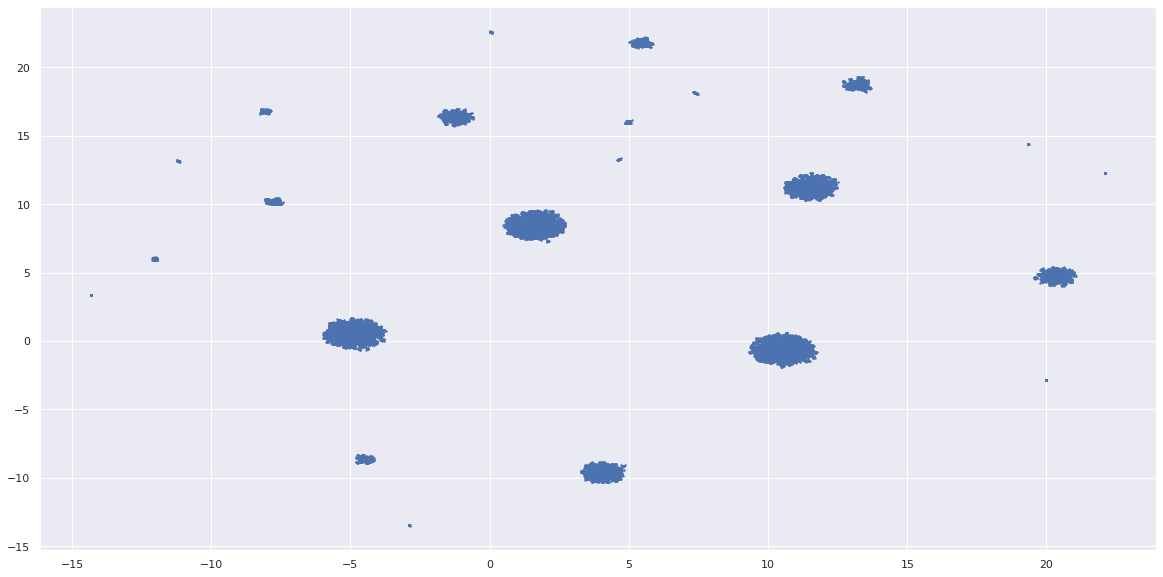

In [22]:
# Combine the numeric and categorical embeddings
intersection = umap.umap_.general_simplicial_set_intersection(mapper1.graph_, 
                                                              mapper2.graph_, 
                                                              weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(mapper1._raw_data, intersection, 
                                                mapper1.n_components, 
                                                mapper1._initial_alpha, 
                                                mapper1._a, mapper1._b, 
                                                mapper1.repulsion_strength, 
                                                mapper1.negative_sample_rate, 
                                                200, 'random', np.random, 
                                                mapper1.metric, mapper1._metric_kwds, False)

# Plot UMAP embeddings
plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [23]:
# Select optimal K from UMAP scatterplot
K_umap = 13

###**5.2. K-Prototype Clustering**

We use K-Prototypes, not K-Modes or K-Means, to accommodate mixed type data (numeric and categorical). K-Prototypes implementation (KPrototypes) by KModes can accept object values directly without the need for encoding (one-hot, label, etc). However, it is important to explicitly identify categorical columns in the parameter.

In [24]:
def feature_index(df, select_dtype='int'):
  """Returns list of indices by dataframe column dtype
  Inputs:
    df = dataframe
    select_dtype = 'int' for numeric columns or 'object' for categorical columns
      default is 'int'
  Output: list object of dataframe indices"""
  df_new = (df.dtypes.to_frame().reset_index()
           ).rename(columns={'index':'feature', 0:'dtype'})
  if select_dtype == 'int':
    feature_index = list(df_new[df_new['dtype'] == 'int'].index)
  if select_dtype == 'object':
    feature_index = list(df_new[df_new['dtype'] == 'object'].index)
  return feature_index

In [25]:
df_kproto = final_data.copy()

# Preprocess numeric features
for col in df_kproto.select_dtypes(exclude='object').columns:
  pt = PowerTransformer()
  df_kproto[col] =  pt.fit_transform(np.array(df_kproto[col]).reshape(-1, 1))

# K-Prototype clustering
kproto = KPrototypes(n_clusters=K_umap, init='Cao', n_jobs=-1)
clusters = kproto.fit_predict(df_kproto, categorical=feature_index(df_kproto, select_dtype='object'))

# Assign cluster label to dataframe
df_kproto['Cluster'] = kproto.labels_
df_kproto

,Region,Program Area,Classification,Citations,Cluster
0,EMEA,Drugs,VAI,0.217412,1
1,NA,Devices,NAI,-1.537548,11
2,NA,Devices,OAI,1.848533,6
3,NA,Devices,VAI,0.217412,9
4,NA,Devices,NAI,-1.537548,11
...,...,...,...,...,...
22905,NA,Devices,VAI,-0.666547,10
22906,NA,Devices,VAI,-0.666547,10
22907,NA,Devices,NAI,-1.537548,11
22908,NA,Drugs,VAI,0.940665,4


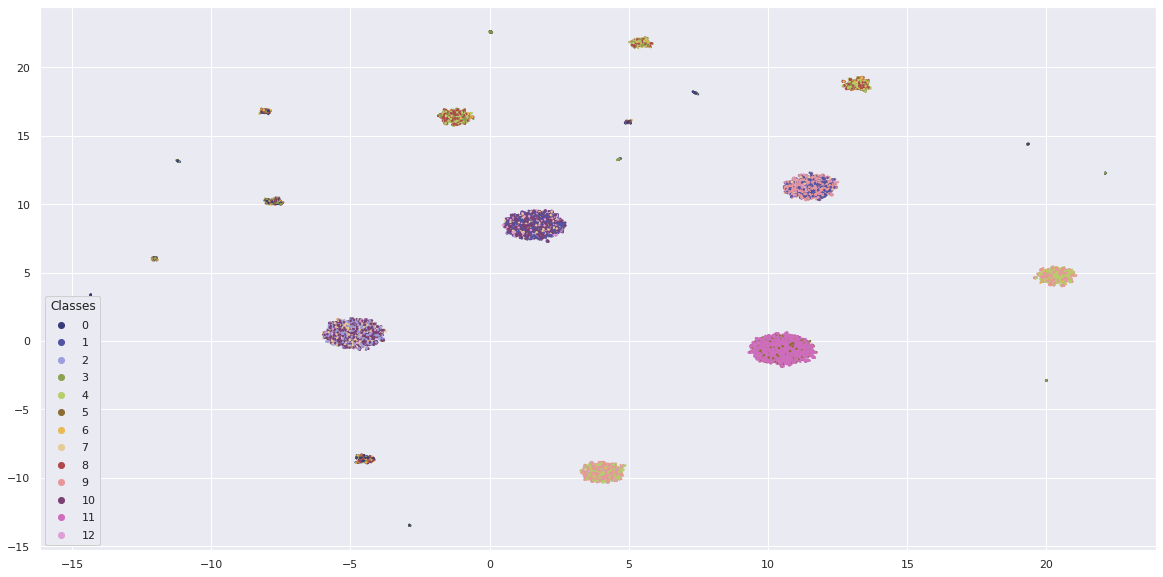

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, 
                     c=clusters, cmap='tab20b', alpha=1.0)
legend = ax.legend(*scatter.legend_elements(num=K_umap),
                    loc='lower left', title='Classes')
ax.add_artist(legend)
plt.show()

###**5.3. Explore Clusters**

After assiging inspections to clusters, we visually explore characteristics of each cluster

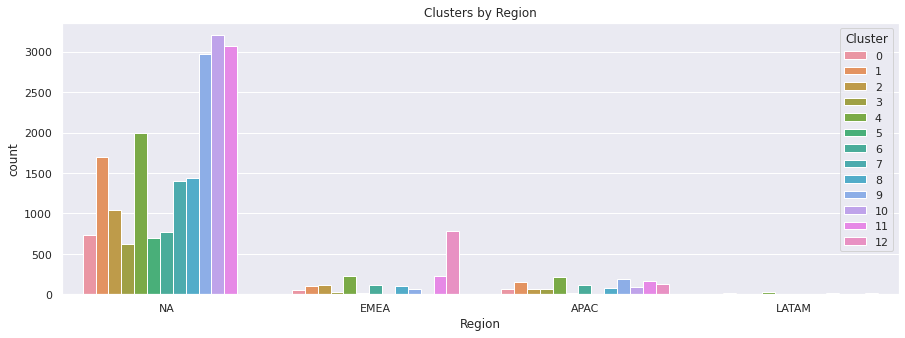

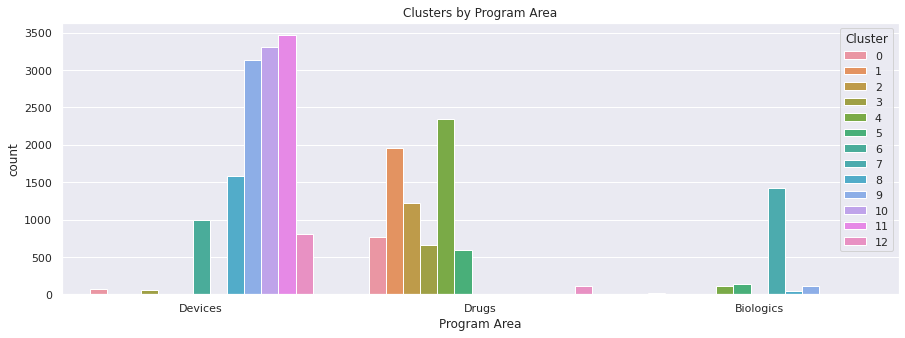

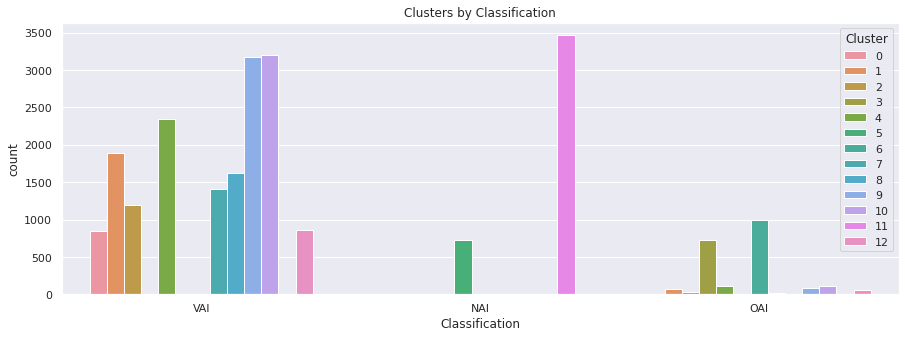

In [27]:
def cluster_summary_plot(df, feature):
  plt.subplots(figsize = (15,5))
  sns.countplot(x=df[feature], 
                order=df[feature].value_counts().index, 
                hue=df['Cluster'])
  plt.title(f'Clusters by {feature}')
  plt.show()

for col in [col for col in list(df_kproto.columns) if col not in ['Cluster', 'Citations']]:
  cluster_summary_plot(df_kproto, feature=col)

In [28]:
(pd.get_dummies(df_kproto)
   .groupby('Cluster')
   .mean()
   .T
   .style.background_gradient(cmap='viridis', axis=1)
)

Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12
Citations,1.750121,0.023753,-0.666547,1.591526,0.794830,-1.537548,1.178774,-0.338977,1.195543,0.439069,-0.414807,-1.537548,-0.101534
Region_APAC,0.071596,0.074719,0.052502,0.097527,0.086284,0.023384,0.115000,0.004228,0.046740,0.057592,0.028762,0.046505,0.136463
Region_EMEA,0.061033,0.051177,0.090238,0.043956,0.091575,0.019257,0.109000,0.005638,0.065191,0.020326,0.000000,0.063836,0.851528
Region_LATAM,0.004695,0.008188,0.004102,0.010989,0.009361,0.000000,0.008000,0.000000,0.001845,0.005236,0.002119,0.001733,0.012009
Region_NA,0.862676,0.865916,0.853158,0.847527,0.812780,0.957359,0.768000,0.990134,0.886224,0.916846,0.969119,0.887926,0.000000
Program Area_Biologics,0.017606,0.000000,0.000000,0.009615,0.043956,0.189821,0.009000,1.000000,0.025215,0.033569,0.000000,0.000000,0.004367
Program Area_Devices,0.080986,0.000000,0.000000,0.081044,0.000000,0.000000,0.991000,0.000000,0.974785,0.966431,1.000000,1.000000,0.879913
Program Area_Drugs,0.901408,1.000000,1.000000,0.909341,0.956044,0.810179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115721
Classification_NAI,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Classification_OAI,0.000000,0.035312,0.022970,1.000000,0.046398,0.000000,1.000000,0.007752,0.000000,0.024022,0.033000,0.000000,0.055677


From the visuals, we can see the following:


*   Inspections classified OAI are often clustered with inspections for devices or drugs, in North America or APAC, and end with high count of citations
*   Inspections classified NAI are often clustered with inspections for devices, in North America or APAC, and end with lowest count of citations (none)
*   Inspections classified VAI vary but are often clustered with inspections for drugs or devices or biologics, in North America, and end with high count of citations (not as high as those classified OAI)
*   Inspections ending with highest count of citations are often clustered with inspections for drugs and, to lesser extent, devices, in North America, and classified VAI
*   Inspections for biologics are often clustered with inspections in North America, classified VAI, and end with low count of citations







###**5.4. Evaluate Clusters with Classification Model**

Lastly, we build a multi-class classification model to predict clusters as a means of evaluating the quality of clusters. If the classification model predicts K-Prototype clusters accurately (e.g. ROC AUC, Precision, Recall, F1), we can conclude that the clusters constructed through K-Prototype are well-defined and distinguishable. In this project, we use XGBoost.

#####**5.4.1. Construct Model Pipeline**

In [29]:
X = df_kproto[['Region','Program Area','Classification','Citations']]
y = df_kproto[['Cluster']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

In [30]:
def get_features(x):
  # Categorical features
  col_cat = [key for key in dict(x.dtypes)
                 if dict(x.dtypes)[key] in ['object', 'bool']]
  # Numeric features
  col_num = [key for key in dict(x.dtypes)
                 if dict(x.dtypes)[key] in ['float64','float32','int32','int64']]
  return col_cat, col_num

In [31]:
def print_predictions(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, multi_class='ovr', average='weighted'):
    print('training auc: '+str(roc_auc_score(y_train, model.predict_proba(X_train), multi_class=multi_class)))
    print('testing auc:  '+str(roc_auc_score(y_test, model.predict_proba(X_test), multi_class=multi_class)))
    print('precision:    '+str(precision_score(y_test, model.predict(X_test), average=average)))
    print('recall:       '+str(recall_score(y_test, model.predict(X_test), average=average)))
    print('f1:           '+str(f1_score(y_test, model.predict(X_test), average=average)))
    print('accuracy:     '+str(accuracy_score(y_test, model.predict(X_test))))
    print('logloss:      '+str(log_loss(y_test, model.predict_proba(X_test))))

In [32]:
col_cat, col_num = get_features(X_train)

pipe_cat = OneHotEncoder(handle_unknown='ignore')
pipe_num = StandardScaler()
preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

#####**5.4.2. Build and Evaluate Model**

In [33]:
model = XGBClassifier(random_state=0)
pipe = make_pipeline(preprocessor, model)
pipe.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['Region', 'Program Area',
                                                   'Classification']),
                                                 ('standardscaler',
                                                  Sta

In [34]:
print_predictions(pipe)

training auc: 1.0
testing auc:  0.9999999341712601
precision:    0.9997828404898251
recall:       0.9997817546922741
f1:           0.9997816505335796
accuracy:     0.9997817546922741
logloss:      0.005152496336031562


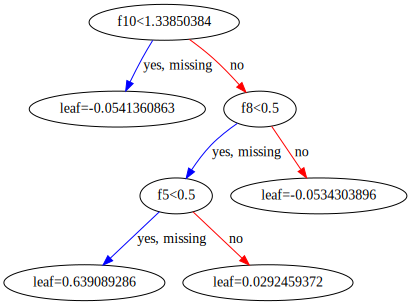

In [35]:
image = xgboost.to_graphviz(pipe.named_steps['xgbclassifier'])
image

#####**5.4.3. Explore Feature Importance**

In [36]:
processor = pipe.named_steps['columntransformer']
ohe_categories = processor.named_transformers_['onehotencoder'].categories_
new_ohe_features = [f'{col}__{val}' for col, vals in zip(col_cat, ohe_categories) for val in vals]
all_features = new_ohe_features + col_num
importance = pd.DataFrame(data=pipe.named_steps['xgbclassifier'].feature_importances_).rename(columns={0:'importance'})
importance['feature'] = all_features
importance = (importance.sort_values(by=['importance'], ascending=False)
             ).reset_index().drop(columns=['index'])
importance

,importance,feature
0,0.242781,Classification__NAI
1,0.204384,Program Area__Biologics
2,0.124548,Classification__OAI
3,0.117719,Program Area__Drugs
4,0.098453,Program Area__Devices
5,0.092091,Citations
6,0.077852,Region__NA
7,0.036951,Region__EMEA
8,0.004472,Classification__VAI
9,0.000749,Region__APAC


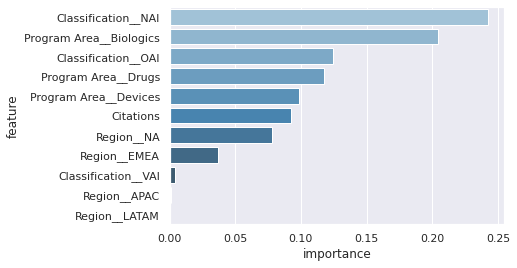

In [37]:
sns.barplot(x='importance', y='feature', data=importance, palette='Blues_d')

From XGBoost's feature importance attribute, we can see the following:

*   Feature *Classification__NAI* is most important feature for cluster prediction
*   Feature *Program Area__Biologics* contribute more to cluster prediction than *Program Area__Drugs*
*   Feature *Classification__OAI* contribute more to cluster prediction than *Classification__VAI*
*   Feature *Region__LATAM* does not contribute 



#**6. Conclusion**




Using UMAP, we can visually see that K-Prototypes produce high quality clusters. Using a very accurate multi-class classification model, we have evidence that the clusters are high quality and easily distinguishable. 

We can conclude the following:

*   Inspections classified OAI are often clustered with inspections for devices or drugs, in North America, and end with high count of citations
*   Inspections classified NAI are often clustered with inspections for devices, in North America, and end with lowest count of citations (none)